\title{Assignment 1}
\author{Thomas Seeberg Christiansen}
\date{\today}

\maketitle

# Part 1

## a) In your opinion, what were the most important turning points in the history of deep learning?
The most important turning points for deep learning, would in my opinion, be the computational increase with the usage of GPUs, the usage of backpropagation, and in the recent years the use of transformers. \
The development of faster hardware meant that training could be done at a much faster rate and larger datasets could be utilized. AlexNet was one of the cornerstones in the GPU boom by using two GTX 580's GPUs training a convolutional neural network. \
An earlier turning point, in the 1980s, was the formation of backpropagation which would allow the networks to learn from their predictions errors and adjust the weigths accordingly. \
Lastly, in recent years, the advancement of transformer-based architecture has given a new boost to deep learning, especially leading to the development of generative pre-trained transformers (GPTs), as seen in models like "ChatGPT". 


## b) Explain the ADAM optimizer.
The Adaptive Moment Estimation (ADAM) optimizer is used to update the weights in a network by combining the ideas of momentum and adaptive learning rates. It works by maintaining two moving averages: one for the gradient (momentum term) and another for the squared gradient (RMSprop term). These averages are bias-corrected, and weights are updated using both terms to adapt the learning rate for each parameter.


## c) Assume data input is a single 30x40 pixel image. First layer is a convolutional layer with 5 filters, with kernel size 3x2, step size (1,1) and padding='valid'. What are the output dimensions?
The output dimensions is given by
$$\frac{W-K+2P}{S}+1$$
where $W$ is the input volume size, $K$ is the kernel size, $S$ the stride, and $P$ the amount of padding. So we have the following:
$$\text{Output Height} = \frac{W-K+2P}{S}+1 = \frac{30-3+2\cdot0}{1}+1=\frac{27}{1}+1=28$$
$$\text{Output Width} = \frac{W-K+2P}{S}+1 = \frac{40-2+2\cdot0}{1}+1=\frac{38}{1}+1=39$$
and since the convolutional layer has 5 filters, the output will have 5 channels. 
Hence, the output dimensions will be 28x39x5. 


## d) Assuming ReLU activations and offsets, and that the last layer is softmax, how many parameters does this network have:
The number of parameters is calculated by looking at the number of layers and number of neurons in each layer. We have 1 input layer, 3 hidden layers, and 1 output layer. Since its a fully connected network the 5 input neurons connect with each of the 1st hidden layer neuron, and so on. Hence, we get the following weights
$$\text{Weights} = 5\times5+5\times5+5\times5+5\times3 = 90$$
We, also, need to look at the biases present for each neuron after the input layer.
$$\text{Biases} = 5+5+5+3 = 18$$
In total we have the following number of parameters:
$$\text{Total} = 90+18 = 109$$


## e) For a given minibatch, the targets are [1,4, 5, 8] and the network output is [0.1,4.4,0.2,10]. If the loss function is "torch.nn.HuberLoss(reduction='mean', delta=1.0)", what is the loss for this minibatch?
The Huber loss function is defined by the following piecewise
$$L_\delta(y-\hat{y}) = \left\{
\begin{array}{ll}
      \frac{1}{2}(y-\hat{y})^2 &  |y-\hat{y}|\le\delta\\
      \delta (|y-\hat{y}|-\frac{1}{2}\delta) & \text{otherwise.} \\
\end{array} 
\right.$$
where $y$ is the target, $\hat{y}$ is the predicted output, $\delta$ the threshold. With the targets $y=[1,4,5,8]$ and predicted outputs $\hat{y}=[0.1,4.4,0.2,10]$, we can compute the loss for each. First we determine each of the cases.
$$\begin{aligned}
      |y-\hat{y}|=|1-0.1|=0.9 \\
      |y-\hat{y}|=|4-4.4|=0.4 \\
      |y-\hat{y}|=|5-0.2|=4.8 \\
      |y-\hat{y}|=|8-10|=2.0
\end{aligned}$$
then the losses
$$\begin{aligned}
      L(1,0.1)=\frac{1}{2}(1-0.1)^2=0.405  \\
      L(4,4.4)=\frac{1}{2}(4-4.4)^2=0.08   \\
      L(5,0.2)=1\cdot(|5-0.2|-\frac{1}{2}\cdot1) = 4.3  \\
      L(8,10)=1\cdot(|8-10|-\frac{1}{2}\cdot1) = 1.5
\end{aligned}$$
In total we have the mean loss as
$$\frac{0.405+0.08+4.3+1.5}{4}=1.57$$
This can also be done with torch by the following code: 

In [1]:
import torch
# Targets and outputs
targets = torch.tensor([1, 4, 5, 8])
outputs = torch.tensor([0.1, 4.4, 0.2, 10])

# Define the Huber loss with delta = 1.0
huber_loss = torch.nn.HuberLoss(reduction='mean', delta=1.0)

# Calculate the loss
loss = huber_loss(outputs, targets)
print(loss.item())

1.571250081062317


# Part 2

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchsummary import summary
import torch_directml
from PIL import Image

## Dataset builder


In [3]:
class InsectDataset(Dataset):
    def __init__(self, annotations_file, img_dir, root_dir, transform=None):
        """"   
        directory setup of the images and labels
        root_dir: Main data directory
        annotations_file: csv file 
        img_dir: image directory
        """
        self.root_dir = root_dir
        annotations_path =  os.path.join(self.root_dir, annotations_file)
        self.img_labels = pd.read_csv(annotations_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Retrieve image via filename
        Open image
        Retrieve label
        transform if needed
        return image and label
        """
        img_path = os.path.join(self.root_dir,self.img_dir, self.img_labels.iloc[idx, 2])
        # print(f"Loading image from: {img_path}")    # Debug print
        image = Image.open(img_path)                

        label = self.img_labels.iloc[idx, 1]        # Retrieve label
        # print(f"----------Labelled = {label}\n")    # Debug print
        if self.transform:
            image = self.transform(image)

        return image, label

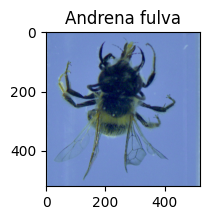

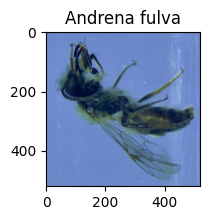

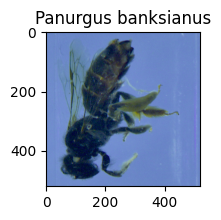

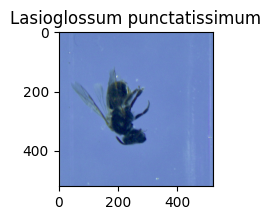

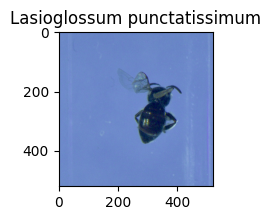

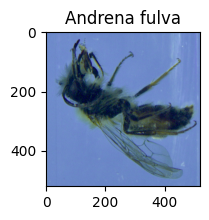

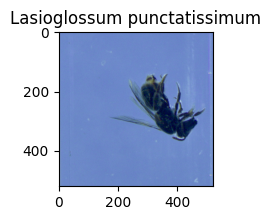

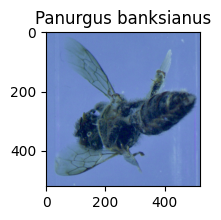

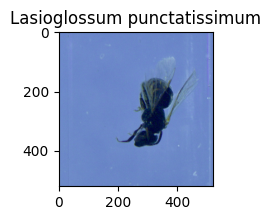

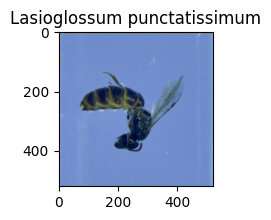

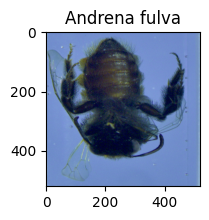

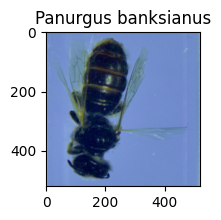

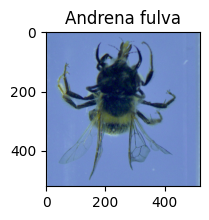

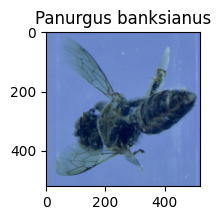

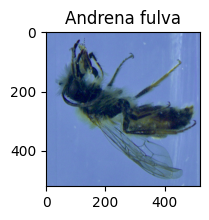

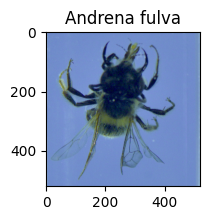

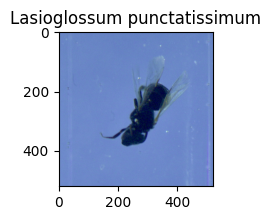

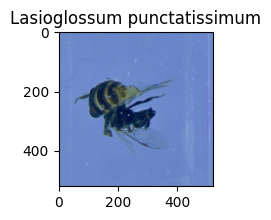

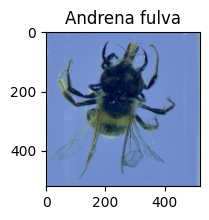

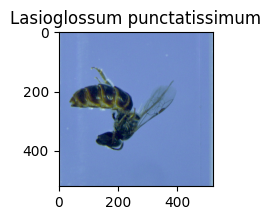

In [4]:
transform = transforms.Compose([
    transforms.Resize((520,520)),
    transforms.ToTensor()])

batch_size = 4

# Set up the dataset.
dataset = InsectDataset(annotations_file='insects.csv', img_dir='Insects',root_dir='Data/', transform=transform)

# Set up the dataset.
trainloader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)

# get some images
dataiter = iter(trainloader)
images, labels = next(dataiter)

for i in range(5): #Run through 5 batches
    images, labels = next(dataiter)
    for image, label in zip(images,labels): # Run through all samples in a batch
        plt.figure(figsize=(4, 2))
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        plt.title(label)

# Part 3

## a)
The data given is already described and I, therefore, just go straight ahead and extract the features and labels from both the trainData and testData ".txt" files. This is easily done using pandas. 

     0         1         2
0  2.0  0.243584  0.539536
1  0.0  0.029800  0.074531
2  4.0 -0.437585 -0.383632
3  2.0 -0.224602  0.407026
4  3.0  0.284853  0.800316


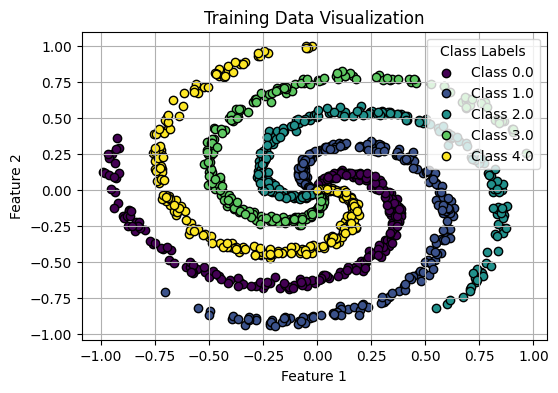

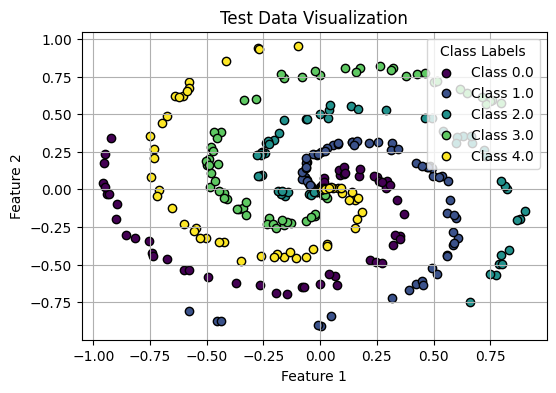

In [5]:
import pandas as pd

# Load the data from .txt files
train_data = pd.read_csv('Data/Part3/trainData.txt', sep='\s+', header=None)
test_data = pd.read_csv('Data/Part3/testData.txt', sep='\s+', header=None)

# The first column is the label, and the second and third columns are the features
train_labels = train_data.iloc[:, 0]  # Labels (first column)
train_features = train_data.iloc[:, 1:]  # Features (second and third columns)

test_labels = test_data.iloc[:, 0]  # Labels (first column)
test_features = test_data.iloc[:, 1:]  # Features (second and third columns)

# Print the first few rows to verify the data
print(train_data.head())

# Define a function to visualize the data
def plot_data(features, labels, title):
    plt.figure(figsize=(6, 4))
    unique_labels = np.unique(labels)  # Get unique class labels
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Generate colors

    # Plot each class with its own color and label
    for label, color in zip(unique_labels, colors):
        idx = labels.to_numpy() == label  # Get indices of the current label
        plt.scatter(features.iloc[idx, 0], features.iloc[idx, 1], label=f'Class {label}', color=color, edgecolor='k')

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(title="Class Labels",loc="upper right")
    plt.grid(True)
    plt.show()

# Plot the training data
plot_data(train_features, train_labels, "Training Data Visualization")

# Plot the test data
plot_data(test_features, test_labels, "Test Data Visualization")


The plots then shows a spiraling arms like a galaxy. We Can easily see the datapoints being classified with their corresponding labels. 

## b)

- **Describe your network**\
The network need to take the two inputs and expand them for more parameters before shrieking to the 5 classes. Therefore, a number of linear layers is needed starting with a input layer taking 2 input features and outputting 256, then a hidden from 256 to 128 and 128 to 64, and then a output layer going from 64 to the 5 classes. Each layer is being followed by a ReLU activation function.
- **Describe your training strategy**\
The network is trained by the Adam optimizer and Cross Entropy loss function with appropriate values for learning rate and batch size parameters. This strategy was build using our prior code from week 3 and 4 where we have seen how certain optimizers and loss functions behave and that the Adam optimizer and Cross Entropy loss function often is the prefered choice due to being efficent. \
Training is performed in batches of 32 with a learning rate of 0.001 running for 100 epochs or until 10 consecutive epochs with no improvement in the loss value. 

In [6]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, number_classes):
        super().__init__()

        # Linear Layers
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 64)
        self.linear4 = nn.Linear(64, number_classes)

        # Activation Function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        return x

# Hyperparameters
input_size = 2
number_classes = 5
batch_size = 32
lr = 0.001

# Device 
device = "cpu"

# Load the training/test data/labels to tensor's
training_data = torch.tensor(train_features.values, dtype=torch.float32)
training_labels = torch.tensor(train_labels.values, dtype=torch.long)
testing_data = torch.tensor(test_features.values, dtype=torch.float32)
testing_labels = torch.tensor(test_labels.values, dtype=torch.long)

# Combine to a dataset
train_dataset = torch.utils.data.TensorDataset(training_data, training_labels)
test_dataset = torch.utils.data.TensorDataset(testing_data, testing_labels)

# Load DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,pin_memory=True)

# Neural Network
model = NeuralNet(input_size, number_classes).to(device)

# Optimizer and Loss
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

class trainNN:

    def __init__(self, model, train_dataloader, test_dataloader, loss_fn, optimizer, num_epochs, patience):
        """
        Inputs
        """
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.patience = patience
        self.reset()
    
    def reset(self):
        """
        reset function. This includes weigths and parameters.
        """
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        self.number_epochs = 1

        def reset_weights(m):
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()
        self.model.apply(reset_weights)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def _train(self, dataloader, model, loss_fn, optimizer):
        """
        Training function 
        """
        size = len(dataloader.dataset)
        model.train()
        total_loss, correct = 0, 0  # Track the total loss for the epoch

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()  # Accumulate loss
        
            # Backpropagation
            model.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            # Print loss for the first batch and then every 5th batch
            if batch == 0 or (batch + 1) % 5 == 0 or (batch + 1) == len(dataloader):
                current = (batch + 1) * len(X) if (batch + 1) < len(dataloader) else size
                print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")   
        avg_loss = total_loss / len(dataloader)  # Calculate average loss for the epoch
        avg_accuracy = correct / size

        self.train_losses.append(avg_loss)  # Store the average loss for the epoch
        self.train_accuracies.append(avg_accuracy) # Store the average accuracy for the epoch

        print(f"Train loss: {avg_loss:>7f}, Accuracy: {(100*avg_accuracy):>0.1f}%")

    def _test(self, dataloader, model, loss_fn):
        """
        Test function
        """
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        self.test_losses.append(test_loss)  # Store the test loss for the epoch
        self.test_accuracies.append(correct)

        print(f"Test Error: \n Avg loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}% \n")
        return round(test_loss,3)
    
    def _plot_results(self):
        """
        Plotting function
        """
        plt.subplot(2,1,1)
        plt.plot(range(1, self.number_epochs+1), self.train_losses, label="Train Loss")
        plt.plot(range(1, self.number_epochs+1), self.test_losses, label="Test Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Testing Loss over Epochs")
        plt.legend()
        plt.show()

        plt.subplot(2,1,2)
        plt.plot(range(1, self.number_epochs+1), self.train_accuracies, label="Train Accuracy")
        plt.plot(range(1, self.number_epochs+1), self.test_accuracies, label="Test Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training and Testing Accuracy over Epochs")
        plt.legend()
        plt.show()
    
    def TrainModel(self):
        """
        Execute training function
        """
        # Early stopping parameters
        best_test_loss = float('inf')
        epochs_without_improvement = 0
        
        for t in range(self.num_epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            # Print number of batches only for the first epoch
            if t == 0:
                num_batches = len(self.train_dataloader)
                print(f"Number of batches: {num_batches}")
            self._train(train_dataloader, model, loss_fn, optimizer)
            current_test_loss = self._test(test_dataloader, model, loss_fn)
            
            # Early stopping logic
            if current_test_loss < best_test_loss:
                best_test_loss = current_test_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
            
            if epochs_without_improvement >= self.patience:
                print(f"Early stopping triggered after {self.number_epochs+1} epochs.")
                break
            print(f"Epochs without improvement: {epochs_without_improvement+1}")
            self.number_epochs += 1
        print("Training completed.")
        self._plot_results()

Epoch 1
-------------------------------
Number of batches: 38
loss: 1.599170  [   32/ 1200]
loss: 1.609358  [  160/ 1200]
loss: 1.588189  [  320/ 1200]
loss: 1.576432  [  480/ 1200]
loss: 1.554649  [  640/ 1200]
loss: 1.562531  [  800/ 1200]
loss: 1.537484  [  960/ 1200]
loss: 1.516447  [ 1120/ 1200]
loss: 1.431424  [ 1200/ 1200]
Train loss: 1.545708, Accuracy: 27.3%
Test Error: 
 Avg loss: 1.454326, Accuracy: 28.4% 

Epochs without improvement: 1
Epoch 2
-------------------------------
loss: 1.401246  [   32/ 1200]
loss: 1.475572  [  160/ 1200]
loss: 1.464338  [  320/ 1200]
loss: 1.466062  [  480/ 1200]
loss: 1.473617  [  640/ 1200]
loss: 1.322773  [  800/ 1200]
loss: 1.429705  [  960/ 1200]
loss: 1.185124  [ 1120/ 1200]
loss: 1.306701  [ 1200/ 1200]
Train loss: 1.378204, Accuracy: 30.8%
Test Error: 
 Avg loss: 1.280153, Accuracy: 31.4% 

Epochs without improvement: 1
Epoch 3
-------------------------------
loss: 1.132774  [   32/ 1200]
loss: 1.412665  [  160/ 1200]
loss: 1.342972  [ 

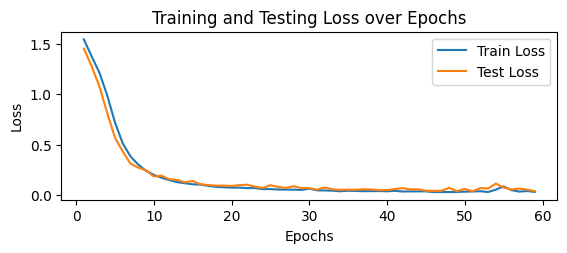

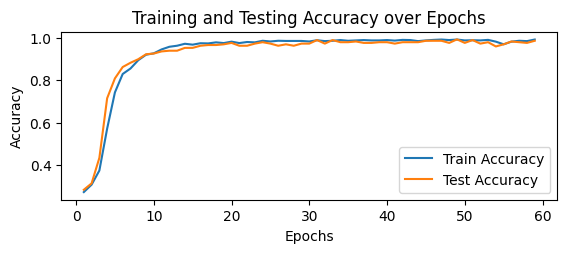

In [7]:
train = trainNN(model, train_dataloader, test_dataloader, loss_fn, optimizer, 100, 10)
train.reset()
train.TrainModel()

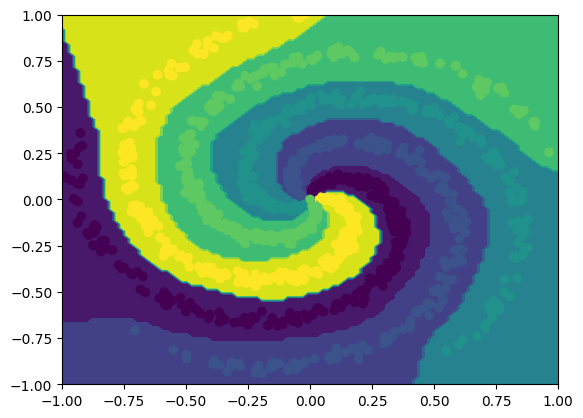

In [8]:
res = 100
x,y=np.meshgrid(np.linspace(-1,1,res),np.linspace(-1,1,res))
xy=np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)
z=model(torch.tensor(xy).float()).detach().numpy()
z=np.argmax(z,1).reshape(res,res)
plt.contourf(x,y,z)
plt.scatter(training_data[:,0],training_data[:,1],c=training_labels)

- **Describe your results and discuss the observed performance**\
The network is able to reach an accuracy of about 97-98% within the 100 epochs. The network often converges after 50-60 epochs with the stopping parameters i've set. However, the last few percentages are hard to reach due to how our data is centered and tightly clustered about (0,0). 
- **Visualize network performance**\
The visualization shows the trouble with classifying the center data, nevertheless, we still see good seperation between the 5 classes. 
